In [30]:
import sys
sys.path.append("../../src/brickwall_sparse")
from utils_sparse import applyG_block_state, get_perms

import numpy as np
import quimb.tensor as qtn
import quimb
from quimb.tensor.tensor_2d_tebd import TEBD2D, LocalHam2D
import scipy
import h5py
import qib
import rqcopt as oc
from scipy.sparse.linalg import expm_multiply

import time
import tracemalloc
tracemalloc.start()


Vlist = []
with h5py.File(f"./results/tfim2d_ccU_SPARSE_103_Lx4Ly4_t0.25_layers15_rS1_niter15_3hloc.hdf5", "r") as f:
    Vlist =  f["Vlist"][:]
control_layers = [0, 4, 5, 9, 10, 14]
perms_qc = [[0, 1], [0, 2], [1, 2], [0, 2], [0, 1], [1, 2], [0, 2], [0, 1], [1, 2]]
Xlists_opt = {}
for i in control_layers:
    with h5py.File(f"./results/tfim2d_ccU_SPARSE_103_Lx4Ly4_t0.25_layers15_niter20_rS5_DECOMPOSE_n9_layer{i}.hdf5", "r") as file:
        Xlists_opt[i] = file[f"Xlist_{i}"][:]

Lx, Ly = (4, 4)
L = Lx*Ly
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 3)
#hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()

perms_v, perms_h = get_perms(Lx, Ly)
"""perms_v, perms_h = (
    [[0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
    [1, 2, 3, 4, 5, 0, 7, 8, 9, 10, 11, 6, 13, 14, 15, 16, 17, 12, 19, 20, 21, 22, 23, 18, 25, 26, 27, 28, 29, 24, 31, 32, 33, 34, 35, 30]],
    [[0, 6, 12, 18, 24, 30, 1, 7, 13, 19, 25, 31, 2, 8, 14, 20, 26, 32, 3, 9, 15, 21, 27, 33, 4, 10, 16, 22, 28, 34, 5, 11, 17, 23, 29, 35], 
    [6, 12, 18, 24, 30, 0, 7, 13, 19, 25, 31, 1, 8, 14, 20, 26, 32, 2, 9, 15, 21, 27, 33, 3, 10, 16, 22, 28, 34, 4, 11, 17, 23, 29, 35, 5]]
)"""
perms_extended = [[perms_v[0]]] + [perms_v]*3 + [[perms_v[0]], [perms_h[0]]] +\
                    [perms_h]*3 + [[perms_h[0]], [perms_v[0]]] + [perms_v]*3 + [[perms_v[0]]]
perms_ext_reduced = [perms_v]*3  + [perms_h]*3 + [perms_v]*3
map_ = {i: (i//Ly, i%Lx) for i in range(L)}

peps = qtn.PEPS.rand(Lx, Ly, bond_dim=1, phys_dim=2, cyclic=True)
peps = peps / peps.norm()
peps_E = peps.copy()
peps_T = peps.copy()
peps_C = peps.copy()

#peps_trotters = {}
#peps_ccUs = {}
#peps_exacts = {}

peps_E = trotter(peps_E, 0.25, L, Lx, Ly, J, g, perms_v, perms_h, 
                     dt=0.25/10, max_bond_dim=3, lower_max_bond_dim=3, treshold=10)
peps_T = trotter(peps_T.copy(), 0.25, L, Lx, Ly, J, g, perms_v, perms_h, 
                     dt=0.25/2, max_bond_dim=3, lower_max_bond_dim=3, treshold=6)

peps_aE = ccU(peps_C, Vlist, perms_extended, control_layers, dagger=False, 
                 max_bond_dim=5, lower_max_bond_dim=5, treshold=12)
#peps_aE2 = ccU(peps_aE.copy(), Vlist, perms_extended, control_layers, dagger=True, 
#                 max_bond_dim=4, lower_max_bond_dim=4, treshold=10)

#peps_trotters[.25] = peps_T.copy()
#peps_ccUs[.25] = peps_aE.copy()
#peps_exacts[.25] = peps_E.copy()

#sv = peps.to_dense()[:, 0]
#sv = expm_multiply(1j * 0.25 * hamil, sv)
#peps_exact_05 = trotter(peps_E.copy(), -0.25, L, Lx, Ly, J, g, perms_v, perms_h, dt=0.25/10, max_bond_dim=3, lower_max_bond_dim=3, treshold=10)
#peps_trotter_05 = trotter(peps_T.copy(), -0.25, L, Lx, Ly, J, g, perms_v, perms_h, dt=0.25/2, max_bond_dim=3, lower_max_bond_dim=3, treshold=10)
#f = quimb.fidelity(peps_trotter.to_dense()[:, 0], sv)
#print("Trotter Fidelity:", f)  # Should be ≈1
#peps_ccU_025 = ccU(peps_C.copy(), Vlist, perms_extended, control_layers, dagger=True, max_bond_dim=3, lower_max_bond_dim=3, treshold=10)
#f = quimb.fidelity(peps_ccU.to_dense()[:, 0], sv)
#print("ccU Fidelity after identity:", f)  # Should be ≈1
#np.linalg.norm(peps_ccU.overlap(peps_trotter))**2


Norm. Trotter
norm finished Trotter
Norm. Trotter
norm finished Trotter
Normalize ccU



KeyboardInterrupt



In [28]:
np.abs(peps_aE.overlap(peps_E))

0.9339844687600849

In [29]:
np.abs(peps_T.overlap(peps_E))

0.9548075169992603

In [109]:
ts = [0.25]

In [110]:
#trotter_Es = {}
for t in ts:
    trotter_Es[t] = []
    for BD in [i for i in range(2, 7)]:
        s = 0
        s += np.abs(peps_trotters[t].compute_local_expectation({((2, 2), (2, 3)): np.kron(Z, Z)}, max_bond=BD))
        s += np.abs(peps_trotters[t].compute_local_expectation({((2, 1), (2, 2)): np.kron(Z, Z)}, max_bond=BD))
        s += np.abs(peps_trotters[t].compute_local_expectation({((2, 2), (3, 2)): np.kron(Z, Z)}, max_bond=BD))
        s += np.abs(peps_trotters[t].compute_local_expectation({((1, 2), (2, 2)): np.kron(Z, Z)}, max_bond=BD))
        s += 3*np.abs(peps_trotters[t].compute_local_expectation({(2, 2): X}, max_bond=BD))
        trotter_Es[t].append(s)
        print(s)

133412.84831230983
145761.81862507557
145538.7929361409
145601.43667930405
145618.21940416069


In [111]:
#ccU_Es = {}
for t in ts:
    ccU_Es[t] = []
    for BD in [i for i in range(2, 7)]:
        s = 0
        s += np.abs(peps_ccUs[t].compute_local_expectation({((2, 2), (2, 3)): np.kron(Z, Z)}, max_bond=BD))
        s += np.abs(peps_ccUs[t].compute_local_expectation({((2, 1), (2, 2)): np.kron(Z, Z)}, max_bond=BD))
        s += np.abs(peps_ccUs[t].compute_local_expectation({((2, 2), (3, 2)): np.kron(Z, Z)}, max_bond=BD))
        s += np.abs(peps_ccUs[t].compute_local_expectation({((1, 2), (2, 2)): np.kron(Z, Z)}, max_bond=BD))
        s += 3*np.abs(peps_ccUs[t].compute_local_expectation({(2, 2): X}, max_bond=BD))
        ccU_Es[t].append(s)
        print(s)

140131.1351592867
152111.08824653015
158829.89082175022
158913.14107626549
158621.72083231912


In [ ]:
#exact_Es = {}
for t in ts:
    for BD in [i for i in range(2, 7)]:
        s = 0
        s += np.abs(peps_exacts[t].compute_local_expectation({((2, 2), (2, 3)): np.kron(Z, Z)}, max_bond=BD))
        s += np.abs(peps_exacts[t].compute_local_expectation({((2, 1), (2, 2)): np.kron(Z, Z)}, max_bond=BD))
        s += np.abs(peps_exacts[t].compute_local_expectation({((2, 2), (3, 2)): np.kron(Z, Z)}, max_bond=BD))
        s += np.abs(peps_exacts[t].compute_local_expectation({((1, 2), (2, 2)): np.kron(Z, Z)}, max_bond=BD))
        s += 3*np.abs(peps_exacts[t].compute_local_expectation({(2, 2): X}, max_bond=BD))
        #exact_Es[t] = s
        print(s)

In [ ]:
ccU_errs = {t: [np.abs((exact_Es[t]-E)/exact_Es[t]) for i, E in enumerate(ccU_Es[t])] for t in ts}
trotter_errs = {t: [np.abs((exact_Es[t]-E)/exact_Es[t]) for i, E in enumerate(trotter_Es[t])] for t in ts}

In [ ]:
ccU_errs

In [ ]:
trotter_errs

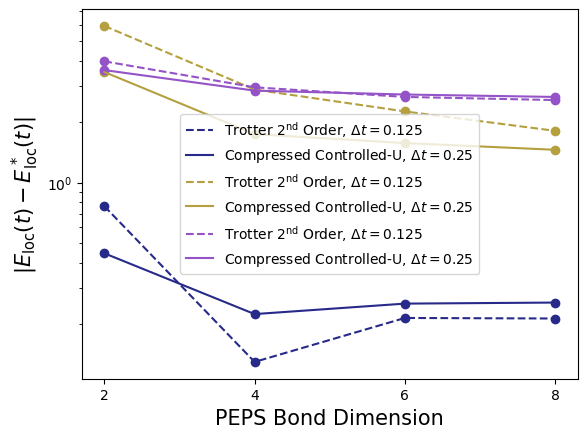

In [124]:
import matplotlib.pyplot as plt

colors = {.25: (39/256, 42/256, 138/256),
          .5 : (181/256, 161/256, 63/256),
          .75: (150/256, 83/256, 201/256)}

for t in [.25, .5, .75]:
    plt.plot([i for i in range(2, 9, 2)], trotter_errs[t], ls='--', color=colors[t], label=r'Trotter $2^{\text{nd}}$ Order, $\Delta t=0.125$')
    plt.scatter([i for i in range(2, 9, 2)], trotter_errs[t], color=colors[t])
    
    plt.plot([i for i in range(2, 9, 2)], ccU_errs[t], color=colors[t], label=r'Compressed Controlled-U, $\Delta t=0.25$')
    plt.scatter([i for i in range(2, 9, 2)], ccU_errs[t], color=colors[t])

plt.xticks([i for i in range(2, 9, 2)])

plt.xlabel('PEPS Bond Dimension', size=15)
plt.ylabel(r'$|E_{\text{loc}}(t)-E^*_{\text{loc}}(t)|$', size=15)

plt.legend()
plt.yscale('log')

In [ ]:
tensors = []
with h5py.File('peps_ccU_MOCK.h5', 'r') as f:
    for key in sorted(f.keys(), key=lambda x: int(x.split('_')[1])):
        data = np.array(f[key][:], dtype=np.float64)  # Force NumPy + valid dtype
        inds = list(f[key].attrs['inds'])
        tensors.append(qtn.Tensor(data=data, inds=inds))

arrays = tuple(
    tuple(tensors[i * Ly + j] for j in range(Ly))
    for i in range(Lx)
)

peps_loaded = qtn.PEPS(arrays)

In [3]:
import rqcopt as oc
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
I2 = np.eye(2)

def trotter(peps, t, L, Lx, Ly, J, g, perms_v, perms_h, dag=False, max_bond_dim=5, 
            dt=0.1, trotter_order=2, treshold=10, lower_max_bond_dim=4):
    nsteps = np.abs(int(np.ceil(t/dt)))
    t = t/nsteps
    indices = oc.SplittingMethod.suzuki(2, int(np.log(trotter_order)/np.log(2))).indices
    coeffs = oc.SplittingMethod.suzuki(2, int(np.log(trotter_order)/np.log(2))).coeffs
    
    hloc1 = g*(np.kron(X, I2)+np.kron(I2, X))/4
    hloc2 = J*np.kron(Z, Z)
    hlocs = (hloc1, hloc2)
    Vlist_start = []
    for i, c in zip(indices, coeffs):
        Vlist_start.append(-1j*c*t*hlocs[i])

    for n in range(nsteps):
        for layer, V in enumerate(Vlist_start):
            i = n*len(Vlist_start)+layer
            for perm in perms_h:
                ordering = {(map_[perm[2*j]], map_[perm[2*j+1]]): V for j in range(L//2)}
                start = time.time()
                t = TEBD2D(peps, ham=LocalHam2D(Lx, Ly, ordering, cyclic=True),
                    tau=-1, D=max_bond_dim if i<treshold else lower_max_bond_dim, chi=1)
                t.sweep(tau=-1)
                peps = t.state
                
            for perm in perms_v:
                ordering = {(map_[perm[2*j]], map_[perm[2*j+1]]): V for j in range(L//2)}
                start = time.time()
                t = TEBD2D(peps, ham=LocalHam2D(Lx, Ly, ordering, cyclic=True),
                    tau=-1, D=max_bond_dim if i<treshold else lower_max_bond_dim, chi=1)
                t.sweep(tau=-1)
                peps = t.state
            #with open(f"trotter_PEPS_log{Lx}{Ly}.txt", "a") as file:
            #    file.write(f"Time step {n}/{nsteps}, layer {layer}/{len(Vlist_start)} applied \n")
            #print(f"Time step {n}/{nsteps}, layer {layer}/{len(Vlist_start)} applied")
    print(f"Norm. Trotter")
    #peps.normalize()
    peps = peps / peps.norm()
    print(f"norm finished Trotter")
    return peps

In [4]:
def ccU(peps, Vlist, perms_extended, control_layers, dagger=False, max_bond_dim=10, lower_max_bond_dim=4, treshold=10):
    for i, V in enumerate(Vlist):
        if dagger or i not in control_layers:
            perms = perms_extended[i]
            for perm in perms:
                ordering = {(map_[perm[2*j]], map_[perm[2*j+1]]): scipy.linalg.logm(V) for j in range(L//2)}
                start = time.time()
                t = TEBD2D(peps, ham=LocalHam2D(Lx, Ly, ordering, cyclic=True),
                    tau=-1, D=max_bond_dim if i<treshold else lower_max_bond_dim, chi=1)
                t.sweep(tau=-1)
                peps = t.state
                #peps /= peps.norm()
                #print(f"Step {i} took {time.time() - start:.2f} seconds")
                #print("Peak memory:", tracemalloc.get_traced_memory())
    print(f"Normalize ccU")
    peps = peps / peps.norm()
    print(f"Normalization of ccU finished")
    return peps